# How to actually build a neural network from blocks?

The webinar is a part of the [Intel Software Student Developer Program for AI](https://software.intel.com/en-us/experts/ambassadors).

## Webinar

* sign up: https://www.crowdcast.io/e/neural-network-blocks/register (6 July 2017)
* speaker: Jakub Czakon, moderator: Dr. Piotr Migdał

## Installation

* Python 3 with Jupyter Notebook and respective libraries (the easiest way is with [Anaconda distribution](https://www.continuum.io/downloads)).
* [Keras](https://keras.io/) (2.x) with [TensorFlow](https://www.tensorflow.org/) backend.
* [keras-sequential-ascii](https://github.com/stared/keras-sequential-ascii) for diagrams

```bash
$ pip install tensorflow
$ pip install keras
$ pip install git+git://github.com/stared/keras-sequential-ascii.git
$ wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
```

## Data

Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.

## More info

For additional information, including [some context for notMNIST](http://p.migdal.pl/2017/04/30/teaching-deep-learning.html#notmnist), see [Learning Deep Learning with Keras](http://p.migdal.pl/2017/04/30/teaching-deep-learning.html).

In [1]:
%matplotlib inline
from time import time

import matplotlib.pyplot as plt

import pandas as pd
from scipy import io
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras_sequential_ascii import sequential_model_to_ascii_printout
from live_loss_plot import PlotLosses

# Keras layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalMaxPool2D

Using TensorFlow backend.


ModuleNotFoundError: No module named 'keras_sequential_ascii'

In [2]:
# load data
data = io.loadmat("../resources/notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# channel for X
X = X.reshape((-1, resolution, resolution, 1))

# 3 -> [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
Y = np_utils.to_categorical(y, 10)

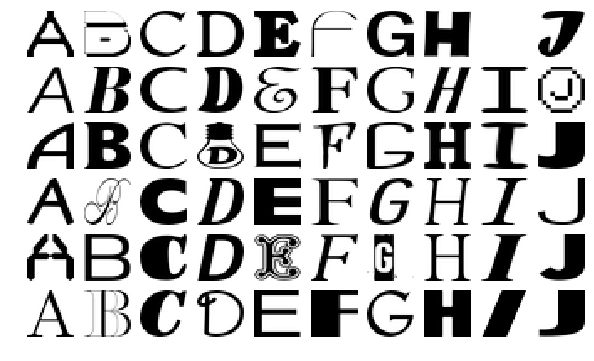

In [3]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))
for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [4]:
# splitting data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    random_state=137)

In [5]:
plot_losses = PlotLosses(figsize=(8, 4))

In [6]:
trained_models, training_times = [], []

In [7]:
# logistic regression
model = Sequential()

model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------      7850   100.0%
             softmax   #####          10


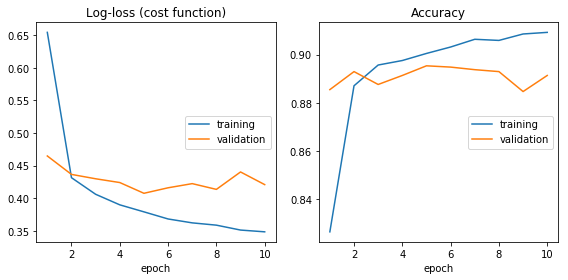

14979/14979 [==============================] - 1s - loss: 0.3485 - acc: 0.9092 - val_loss: 0.4209 - val_acc: 0.8913


In [8]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [9]:
# MLP
model = Sequential()

model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------     50240    98.0%
                tanh   #####          64
               Dense   XXXXX -------------------       650     1.0%
             softmax   #####          10


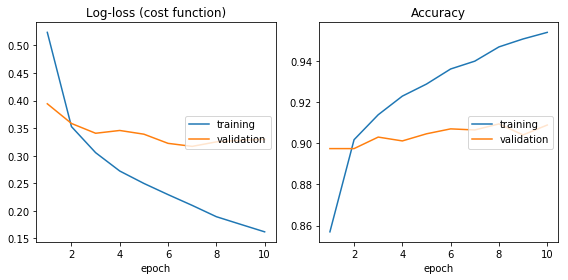

14979/14979 [==============================] - 1s - loss: 0.1621 - acc: 0.9541 - val_loss: 0.3298 - val_acc: 0.9089


In [10]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [11]:
# 1 conv
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
             Flatten   ||||| -------------------         0     0.0%
                       #####       10816
               Dense   XXXXX -------------------    108170    99.0%
             softmax   #####          10


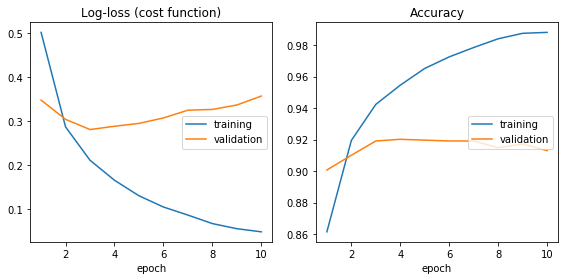

14979/14979 [==============================] - 4s - loss: 0.0474 - acc: 0.9880 - val_loss: 0.3566 - val_acc: 0.9130


In [12]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [13]:
# 1 conv + max pool
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     13   13   16
             Flatten   ||||| -------------------         0     0.0%
                       #####        2704
               Dense   XXXXX -------------------     27050    99.0%
             softmax   #####          10


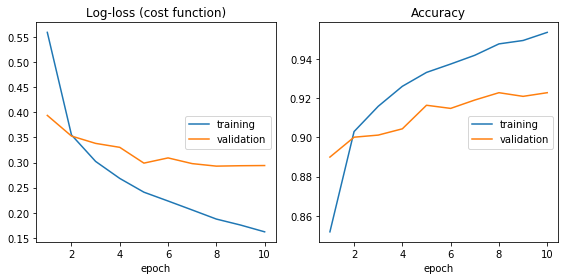

14979/14979 [==============================] - 4s - loss: 0.1619 - acc: 0.9536 - val_loss: 0.2940 - val_acc: 0.9228


In [14]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [15]:
# 2x (conv + max pool)
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     1.0%
                relu   #####     26   26   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     13   13   16
              Conv2D    \|/  -------------------      4640    36.0%
                relu   #####     11   11   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      5    5   32
             Flatten   ||||| -------------------         0     0.0%
                       #####         800
               Dense   XXXXX -------------------      8010    62.0%
             softmax   #####          10


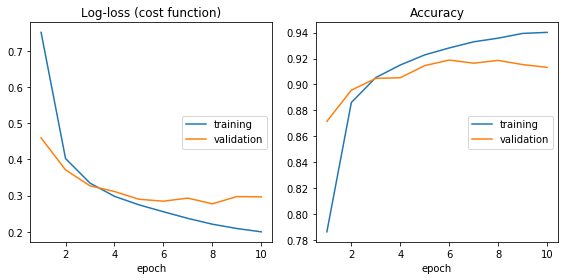

14979/14979 [==============================] - 7s - loss: 0.1997 - acc: 0.9402 - val_loss: 0.2961 - val_acc: 0.9132


In [16]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [17]:
# 2x (conv + max pool) more channels
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(MaxPool2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       640     1.0%
                relu   #####     26   26   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     13   13   64
              Conv2D    \|/  -------------------     36928    68.0%
                relu   #####     11   11   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      5    5   64
             Flatten   ||||| -------------------         0     0.0%
                       #####        1600
               Dense   XXXXX -------------------     16010    29.0%
             softmax   #####          10


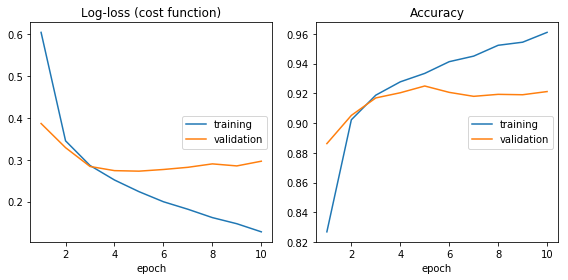

14979/14979 [==============================] - 15s - loss: 0.1278 - acc: 0.9610 - val_loss: 0.2965 - val_acc: 0.9212


In [18]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [19]:
# 2x (2xconv + max pool)
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
              Conv2D    \|/  -------------------      2320    10.0%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640    21.0%
                relu   #####     10   10   32
              Conv2D    \|/  -------------------      9248    43.0%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   32
             Flatten   ||||| -------------------         0     0.0%
                       #####         512
               Dense   XXXXX -------------------      5130    23.0%
             softma

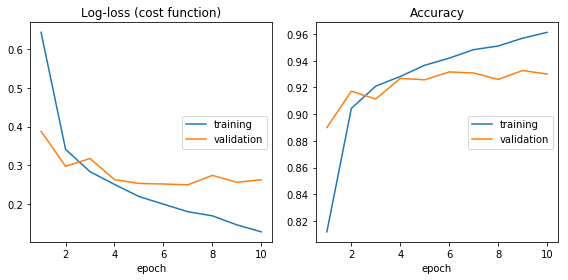

14979/14979 [==============================] - 14s - loss: 0.1277 - acc: 0.9613 - val_loss: 0.2623 - val_acc: 0.9300


In [20]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [21]:
# 2x (2xconv + max pool) dropout bn
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
  BatchNormalization    Î¼|Ï  -------------------        64     0.0%
                       #####     26   26   16
              Conv2D    \|/  -------------------      2320    10.0%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640    21.0%
                relu   #####     10   10   32
  BatchNormalization    Î¼|Ï  -------------------       128     0.0%
                       #####     10   10   32
              Conv2D    \|/  -------------------      9248    42.0%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
          

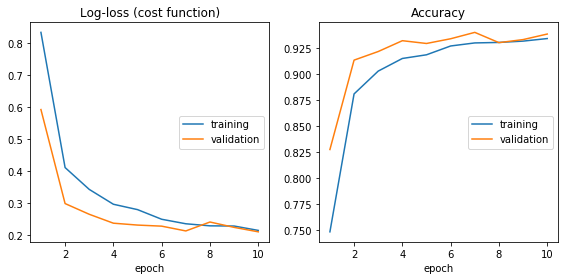

14979/14979 [==============================] - 19s - loss: 0.2148 - acc: 0.9340 - val_loss: 0.2103 - val_acc: 0.9383


In [22]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [23]:
# 2x (2xconv + max pool) dropout bn
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
  BatchNormalization    Î¼|Ï  -------------------        64     0.0%
                       #####     26   26   16
              Conv2D    \|/  -------------------      2320    10.0%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640    21.0%
                relu   #####     10   10   32
  BatchNormalization    Î¼|Ï  -------------------       128     0.0%
                       #####     10   10   32
              Conv2D    \|/  -------------------      9248    42.0%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
          

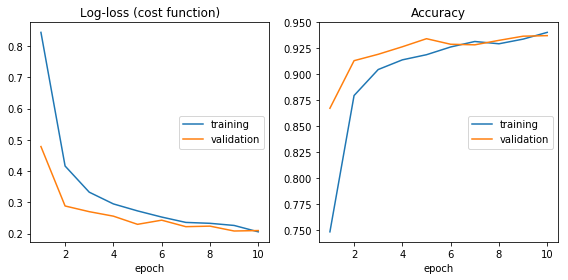

14979/14979 [==============================] - 19s - loss: 0.2060 - acc: 0.9401 - val_loss: 0.2100 - val_acc: 0.9370


In [24]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [25]:
# 2x (2xconv + max pool + dense) dropout bn
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
  BatchNormalization    Î¼|Ï  -------------------        64     0.0%
                       #####     26   26   16
              Conv2D    \|/  -------------------      2320     2.0%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640     5.0%
                relu   #####     10   10   32
  BatchNormalization    Î¼|Ï  -------------------       128     0.0%
                       #####     10   10   32
              Conv2D    \|/  -------------------      9248    11.0%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
          

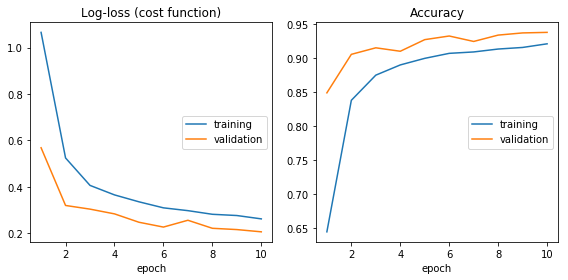

14979/14979 [==============================] - 19s - loss: 0.2612 - acc: 0.9210 - val_loss: 0.2053 - val_acc: 0.9378


In [26]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

In [27]:
# fully conv
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(GlobalMaxPool2D())

model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.0%
                relu   #####     26   26   16
  BatchNormalization    Î¼|Ï  -------------------        64     0.0%
                       #####     26   26   16
              Conv2D    \|/  -------------------      2320     5.0%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640    10.0%
                relu   #####     10   10   32
  BatchNormalization    Î¼|Ï  -------------------       128     0.0%
                       #####     10   10   32
              Conv2D    \|/  -------------------      9248    20.0%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
          

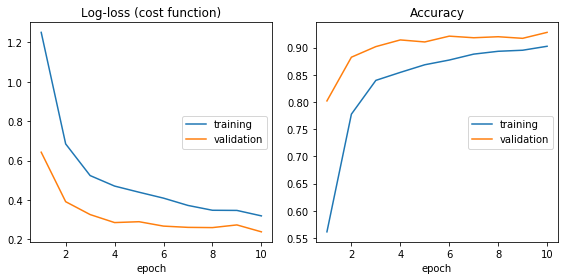

14979/14979 [==============================] - 19s - loss: 0.3197 - acc: 0.9026 - val_loss: 0.2387 - val_acc: 0.9282


In [28]:
start_time = time()
# train model
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, Y_test), callbacks=[plot_losses])
end_time = time()
trained_models.append(model)
training_times.append(end_time-start_time)

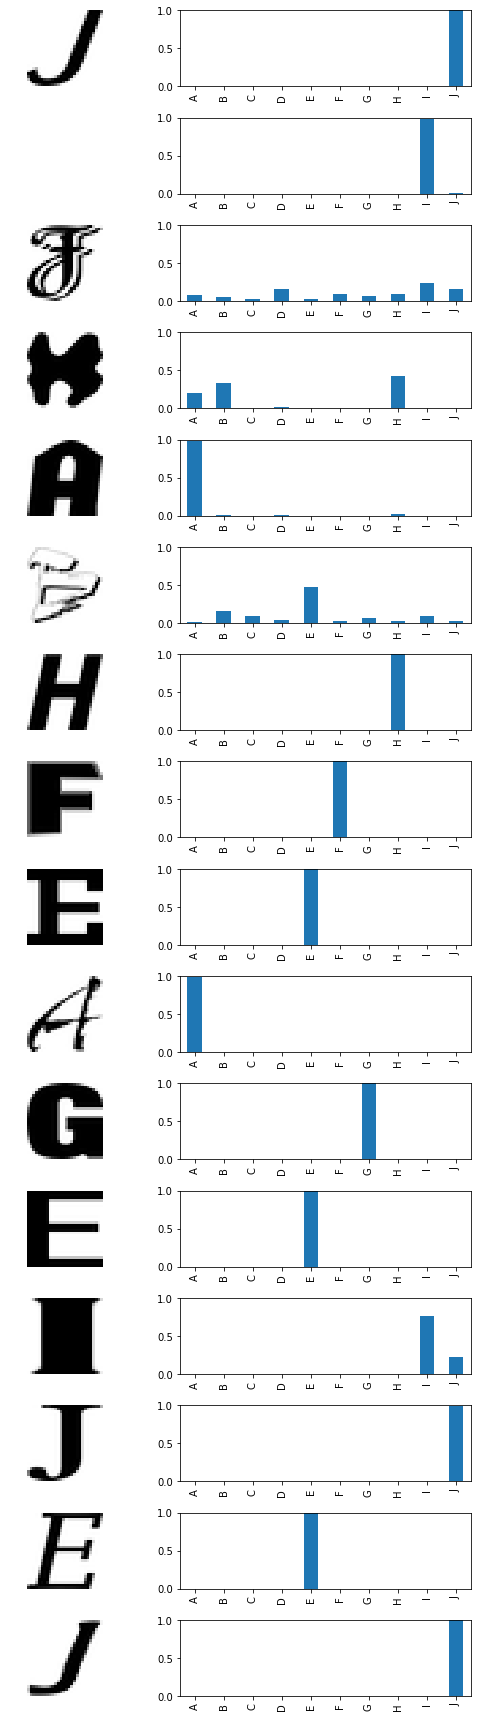

In [29]:
# example predictions
predictions = model.predict(X_test)

rows = 16
fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
for i in range(rows):
    ax = axs[i,0]
    idx = np.random.randint(len(X_test))
    ax.imshow(X_test[idx,:,:,0],
              cmap='Greys', interpolation='none')
    ax.axis('off')
        
    pd.Series(predictions[idx], index=list("ABCDEFGHIJ")).plot('bar', ax=axs[i,1], ylim=[0,1])

plt.tight_layout()

# Bonus: Grid Plots

In [30]:
%load_ext autoreload
%autoreload 2

from grid_plot import score_model_grid, plot_complexity, plot_loss_grid, plot_acc_grid

model_names = ['logistic regression', 
'multi layer perceptron', 
'1 conv layer 16 filters 3x3',
'1 conv layer 16 filters 3x3 with maxpool',
'2 conv layer 16 and 32 filters 3x3 with maxpool',
'2 conv layer 64 filters 3x3 with maxpool',
'2 blocks of 2 conv layer 16 and 32 filters 3x3 with maxpool',
'2 blocks of 2 conv layer 16 and 32 filters 3x3 with maxpool and dropout',
'2 blocks of 2 conv layer 16 and 32 filters 3x3 with maxpool with dropout with batch normalization',      
'2 blocks of 2 conv layer 16 and 32 filters 3x3 with maxpool, dense layer with dropout with batch normalization',
'2 blocks of 2 conv layer 16 and 32 filters 3x3 with maxpool, global average pooling layer with dropout with batch normalization'
]

model_grid = score_model_grid(trained_models, model_names, training_times, 
                              X_train, Y_train, X_test, Y_test)

model_grid.to_csv('model_grid_scores.csv', index=None)

 5472/14979 [=========>....................] - ETA: 0s

/home/jakub.czakon/.webinar/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


3712/3745 [============================>.] - ETA: 0s

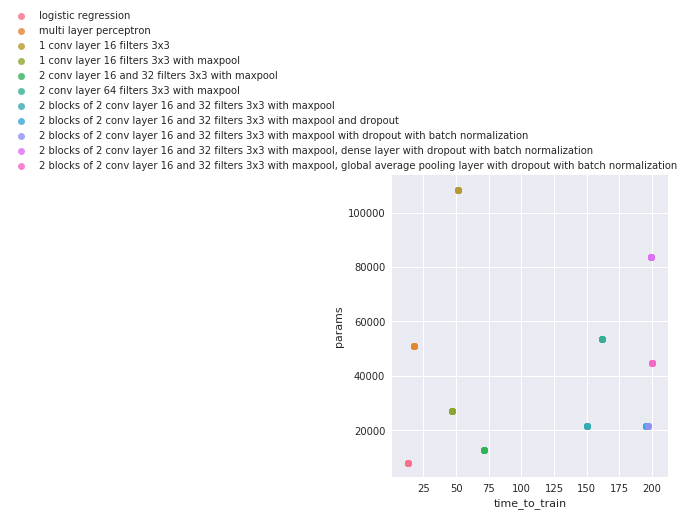

In [55]:
plot_complexity(save_path='model_grid_scores.csv');

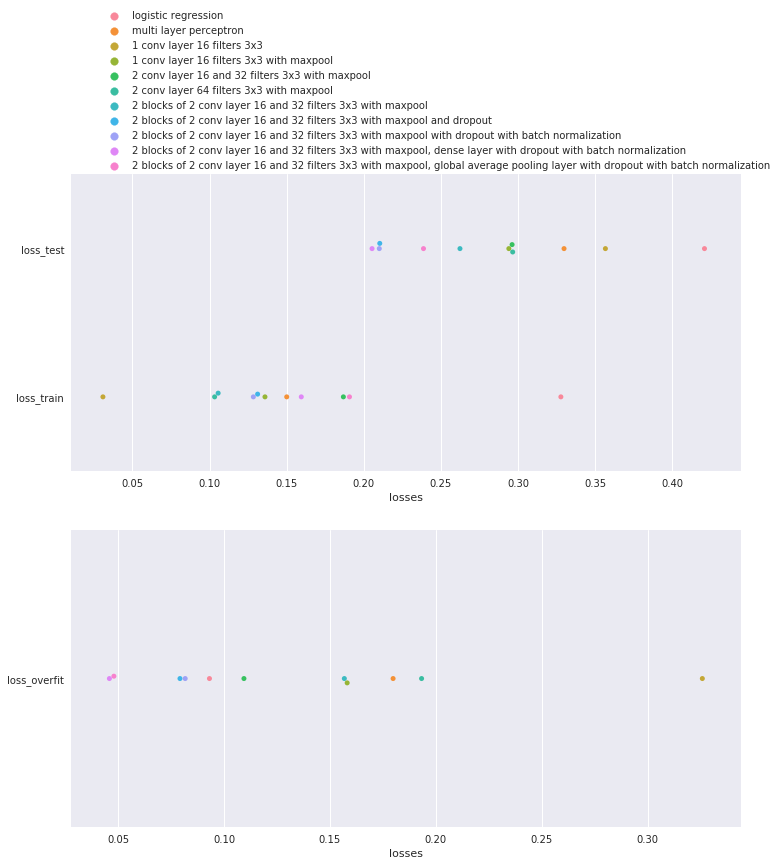

In [51]:
plot_loss_grid(save_path='model_grid_scores.csv');

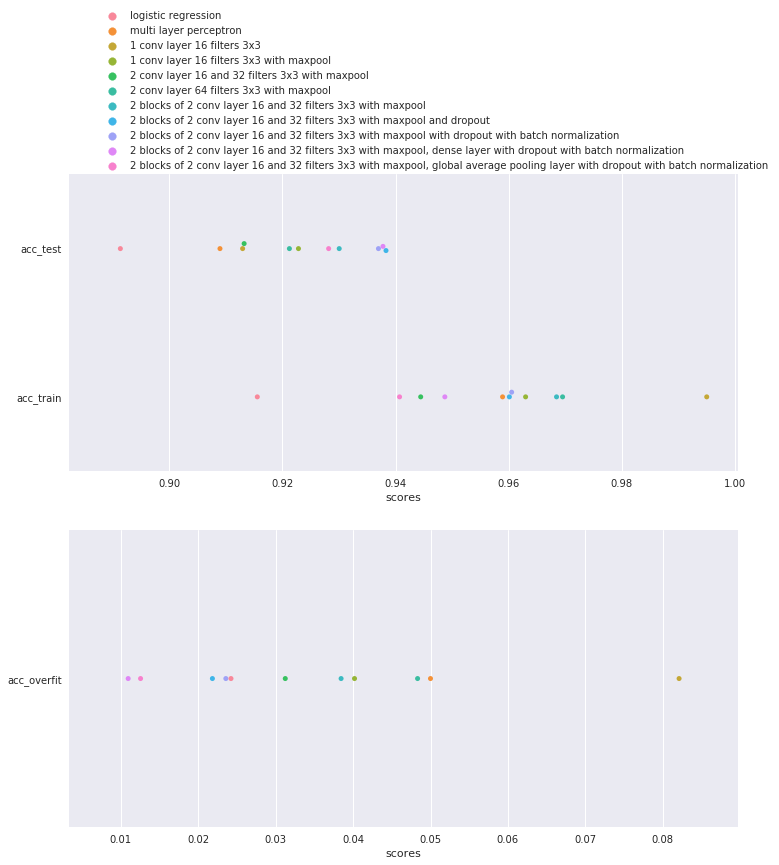

In [50]:
plot_acc_grid(save_path='model_grid_scores.csv');